# Car-Price Prediction Project

### Importing Packages

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading Data

In [39]:
df = pd.read_csv('data.csv')

In [40]:
len(df)

11914

In [41]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [42]:
##This is to replace spaces with underscores and lowercase all column names

df.columns = df.columns.str.lower().str.replace(' ','_') 

In [43]:
##This is to select only columns with string values, and then lowercase and replace spaces with underscores for them

string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ','_')
    

In [44]:
##Checking if our changes worked

df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


/opt/anaconda3/envs/ML/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='msrp'>

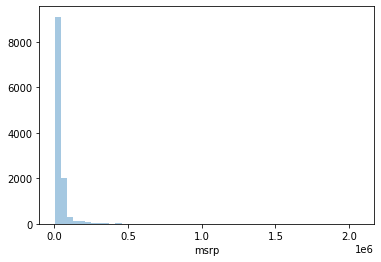

In [45]:
##Creating a histogram to check status of our target variable MSRP

sns.distplot(df.msrp,kde=False)

<AxesSubplot:xlabel='msrp'>

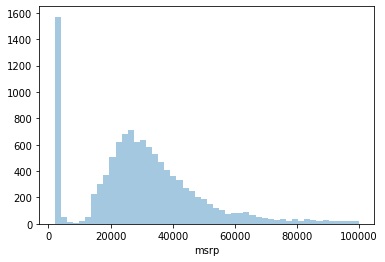

In [46]:
##The data has a long tail. So let's try looking at just the values below 100,000

sns.distplot(df.msrp[df.msrp < 100000], kde=False)

<AxesSubplot:xlabel='msrp'>

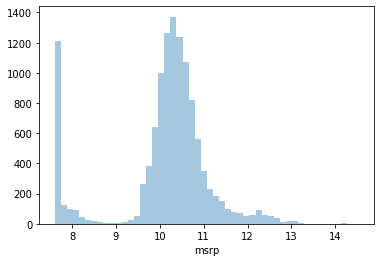

In [47]:
log_price = np.log1p(df.msrp) ##Converting MSRP to log
sns.distplot(log_price , kde=False)

In [48]:
##We have achieved a normal-ish distribution, which is best for linear regression

### Checking for Missing Values

In [49]:
##Checking how many columns (features) have null/missing values

df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### Split into Validation, Test & Training

In [50]:
##Get the number of rows in the dataframe

n = len(df)

##Calculate the number of rows that goes into validation, test and training

n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = int(n_val + n_test)

##Fix a random seed to make results reproducible, then create a NumPy array with indices 0 to n-1

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

##Use the array with indices to get a shuffled dataframe

df_shuffled = df.iloc[idx]

##Split shuffled dataframe into training, validation and testing

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [51]:
##Apply log transformation to these dataframes

y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

##Remove MSRP, the target variable to avoid accidentally using it later (optional)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

## Training the Model

In [59]:
##We define linear regression implemented with NumPy

def linear_regression(X,y):
    ones = np.ones(X.shape[0]) ##Create an array that contains only 1s
    X = np.column_stack([ones,X]) ##Add this array of 1s as first column of X
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    ##Split weights vector into the bias and rest of weights
    return w[0], w[1:]

In [60]:
##We use the features engine_hp, engine_cylinders, highway_mpg, city_mpg and popularity

base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

##Fill missing values with 0

df_num = df_num.fillna(0)

In [61]:
##Convert dataframe into a NumPy array

X_train = df_num.values

##Use X_train as input for our linear regression function

w_0, w = linear_regression(X_train, y_train)


In [62]:
##Having trained the model, let's apply it to the training data and see how well it predicts

y_pred = w_0 + X_train.dot(w)

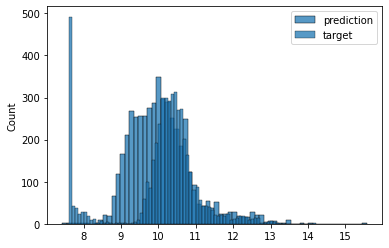

In [66]:
##Compare predictions to actual prices

sns.histplot(y_pred, label = 'prediction')
sns.histplot(y_train, label='target')
plt.legend()

## Computing Root Mean Square Error (RMSE)

In [67]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [69]:
##Evaluating the quality of the model

rmse(y_train,y_pred)

0.7589825592176956

In [70]:
##This means that on average, the model's predictions are off by 0.75